In [1]:
import librosa
from ipywidgets import Audio
import IPython.display
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import numpy as np
import scipy
import matplotlib.pyplot as plt
import soundfile as sf
import torch
from tqdm.notebook import tqdm
from functools import partial

from gfm_iaif import gfm_iaif
from utils import h1h2, weighted_log_mag_mse_loss
from tract_proxy import VocalTractProxy
from optimize import TractControlsOptimizer
from glottis import Glottis

# from dask.distributed import LocalCluster

Plan:


* Get glcoeffs vtcoefffs lpcoeffs
* Construct glsignal1 vtsignal1
* Construct excitation signal

* For GL and VL::::
    * Get roots 
    * Filter roots img > 0
    * Keep other roots
    * 
    * Compute freqz from phases
    * Distort phases to make new roots
    * Compute poly from new roots
    * 
    * Make sure coeffs start in one, normalize

* New signal = excitation * newGL * newVT

In [2]:
# input, fs = librosa.load("C#2.wav")
# Audio.from_file("C#2.wav", loop=False)
audio_input, fs = librosa.load("C2.wav")  #("0_47.wav")
IPython.display.Audio(data=audio_input, rate=fs, autoplay=True)

In [3]:
framelength = 1024
hoplength = 128
fmin, fmax = 70, 500
ncilinders = 44

In [4]:
input_frames = librosa.util.frame(audio_input, frame_length=framelength, hop_length=hoplength)
nframes = input_frames.shape[1]

In [5]:
# Do i need to compute f0???
f0 = np.concatenate([librosa.yin(input_frames[:,i] / np.max(np.abs(input_frames[:,i])), 
                                 fmin=fmin, fmax=fmax, frame_length=framelength, hop_length=hoplength, sr=fs, 
                                 center=False, trough_threshold=0.1) for i in range(nframes)])
f0.mean()

259.1823654960376

### Inverse filtering with GFM-IAIF

In [6]:
vtcoeffs = np.empty((nframes, ncilinders+1))
glcoeffs = np.empty((nframes,4))
lipcoeffs = np.empty((nframes, 2))

for i in range(nframes):
    frame = input_frames[:, i]
    vtcoeffs[i,:], glcoeffs[i,:], lipcoeffs[i,:] = gfm_iaif(frame, n_vt=ncilinders)

In [13]:
# let's get the sounds isolated
glottis_iaif = np.zeros_like(audio_input)
vocalt_iaif = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = input_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    glottis_iaif[idx] += scipy.signal.lfilter(vtcoeffs[i,:], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
    #vocalt_iaif[idx]  += scipy.signal.lfilter(glcoeffs[i,:], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
glottis_frames = librosa.util.frame(glottis_iaif, frame_length=framelength, hop_length=hoplength)

IPython.display.Audio(data=glottis_iaif.T.flatten(), rate=fs,autoplay=True)

In [30]:
# A la excitacion le hemos sacado primero el vocal tract, y ahora le sacamos la glottis
glottis_frames = librosa.util.frame(glottis_iaif, frame_length=framelength, hop_length=hoplength)
excitation_iaif = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = glottis_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    excitation_iaif[idx] += scipy.signal.lfilter(glcoeffs[i,:], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
IPython.display.Audio(data=excitation_iaif.T.flatten(), rate=fs,autoplay=True)

In [145]:
# Glottis roots

In [23]:
valid_frame_mask = np.empty(nframes)
glottis_poles = np.empty((nframes,3),dtype=np.complex128)
glottis_phase_poles = np.empty((nframes,1),dtype=np.complex128)
glottis_real_poles = np.empty((nframes,1),dtype=np.complex128)
glottis_frequencies = np.empty((nframes,1))
for n in range(nframes):
    poles = np.roots(glcoeffs[n,:])
    phase_poles = np.array([r for r in poles if np.imag(r) > 0])
    if phase_poles.shape[0]==1:
        glottis_poles[n,:] = poles.copy()        
        glottis_phase_poles[n,:] = phase_poles.copy()
        glottis_real_poles[n,:] = np.array([r for r in poles if np.imag(r) == 0])
        glottis_frequencies[n,:] = np.arctan2(phase_poles.imag, phase_poles.real) * (fs / (2 * np.pi))
        valid_frame_mask[n] = True
    else:
        glottis_poles[n,:] = 0  
        glottis_phase_poles[n,:] = 0
        glottis_real_poles[n,:] = 0
        glottis_frequencies[n,:] = 0
        valid_frame_mask[n] = False

print("Glottal frequencies:", glottis_frequencies[650,:])

Glottal frequencies: [290.23978019]


In [24]:
valid_frame_mask = np.empty(nframes)

vt_poles = np.zeros((nframes,ncilinders),dtype=np.complex128)
vt_phase_poles = np.empty((nframes,int(ncilinders/2)),dtype=np.complex128)
vt_frequencies = np.empty((nframes,int(ncilinders/2)))
for n in range(nframes):    
    poles = np.roots(vtcoeffs[n,:])
    phase_poles = np.array([r for r in poles if np.imag(r) > 0])
    if phase_poles.shape[0] == ncilinders/2:
        vt_poles[n,:] = poles.copy()
        vt_phase_poles[n,:] = phase_poles.copy()    
        freqs = np.arctan2(phase_poles.imag, phase_poles.real) * (fs / (2 * np.pi)) 
        idx_sort = freqs.argsort() 
        vt_frequencies[n,:] = freqs[idx_sort].real
        vt_phase_poles[n,:] = vt_phase_poles[n,:][idx_sort]
        valid_frame_mask[n] = True
    else:
        vt_poles[n,:] = 0
        vt_phase_poles[n,:] = 0
        vt_frequencies[n,:] = 0
        valid_frame_mask[n] = False
        
print("Vocal tract frequencies:", vt_frequencies[650,:])

Vocal tract frequencies: [  505.18251135   808.49098578  1261.96543783  1560.80639929
  2287.31746008  2976.82632358  3414.10168152  4033.76789259
  4354.98095741  4888.12051848  5241.27618493  5976.3100895
  6126.77236363  6549.71780178  6877.15850547  7194.72608989
  8437.47691002  8793.40743828  9360.21519366  9704.61328594
 10166.9638546  10447.56840124]


In [25]:
glottal_shift = 520 *(2*np.pi)/fs
new_glottis_phase_poles = np.where(valid_frame_mask,
                                  (glottis_phase_poles[:,0])*np.exp(glottal_shift*1j),0)

np.arctan2(new_glottis_phase_poles[650].imag, new_glottis_phase_poles[650].real) * (fs / (2 * np.pi)) 

810.2397801896807

In [26]:
np.stack( (new_glottis_phase_poles,
                                     np.conjugate(new_glottis_phase_poles),
                                     glottis_real_poles[:,0]) ).T.shape

(1286, 3)

In [27]:
new_glottis_poles = np.empty((nframes,3))
new_glcoeffs = np.empty((nframes,4))

new_glottis_poles = np.stack( (new_glottis_phase_poles,
                                     np.conjugate(new_glottis_phase_poles),
                                     glottis_real_poles[:,0]) ).T
#esto no me funciona, tengo que hacer el loop como un pobre campesino
#np.where(valid_frame_mask,np.poly(new_glottis_poles),0)
for n in range(nframes):
    if valid_frame_mask[n]:
        new_glcoeffs[n,:] = np.poly(new_glottis_poles[n])
    else:
        new_glcoeffs[n,:] = glcoeffs[n,:]

new_glcoeffs[650,:], glcoeffs[650,:]

(array([ 1.        , -2.527835  ,  2.1423266 , -0.59442655]),
 array([ 1.        , -2.57320411,  2.1703317 , -0.59442655]))

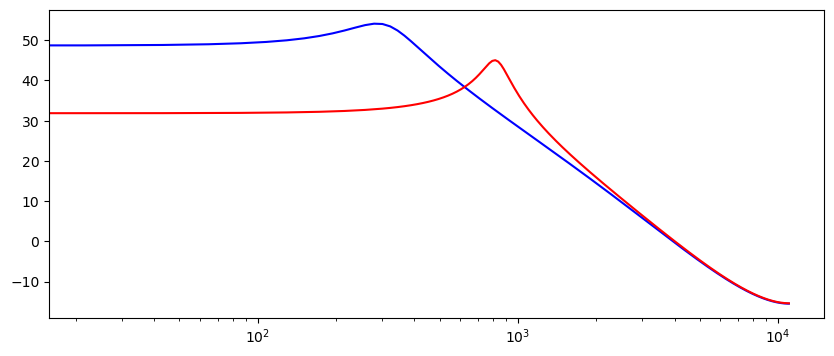

In [28]:
plt.figure(figsize=(10,4))
freqresp = np.empty((framelength//2, nframes), dtype=np.complex128)
w, ref = scipy.signal.freqz([1], glcoeffs[200,:])
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='blue')
w, ref = scipy.signal.freqz([1],new_glcoeffs[200,:]) ### HAY QUE NORMALIZAR LA ENERGIA ?????!!!!
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='red')
plt.semilogx()
plt.show()

In [17]:
vt_shift = [200 *(2*np.pi)/fs , +300 *(2*np.pi)/fs , 450 *(2*np.pi)/fs ]
new_vt_phase_poles = vt_phase_poles.copy()
for n in range(nframes):
    for s,shift in enumerate(vt_shift):
        new_vt_phase_poles[n,s] = new_vt_phase_poles[n,s]*np.exp(-shift*1j)  # F1

(np.arctan2(new_vt_phase_poles.imag, new_vt_phase_poles.real) * (fs / (2 * np.pi)))[650,:]

array([  305.18251135,   508.49098578,   811.96543783,  1560.80639929,
        2287.31746008,  2976.82632358,  3414.10168152,  4033.76789259,
        4354.98095741,  4888.12051848,  5241.27618493,  5976.3100895 ,
        6126.77236363,  6549.71780178,  6877.15850547,  7194.72608989,
        8437.47691002,  8793.40743828,  9360.21519366,  9704.61328594,
       10166.9638546 , 10447.56840124])

In [18]:
new_vt_phase_poles.shape

(1286, 22)

In [19]:
new_vt_poles = np.concatenate( (new_vt_phase_poles,
                                     new_vt_phase_poles.conjugate()) , axis=1)

new_vtcoeffs = np.empty((nframes,ncilinders+1))

for n in range(nframes):
    if valid_frame_mask[n]:
        new_vtcoeffs[n,:] = np.poly(new_vt_poles[n,:])
    else:
        new_vtcoeffs[n,:] = vtcoeffs[n,:]    
    
new_vtcoeffs[650,:], vtcoeffs[650,:]

(array([ 1.        , -0.28227693, -0.13748508, -0.13230479, -0.76895752,
        -0.01512936,  0.20460134, -0.50311574,  0.71778145,  0.12884943,
        -0.05577678,  0.35530662,  0.09983406, -0.48485716,  0.51343053,
        -0.68442166,  0.00216989,  0.52688703, -0.28464541,  0.0116453 ,
         0.46983844, -0.68377852,  0.3994698 , -0.05209249, -0.15012004,
         0.08069014,  0.01262829, -0.36549185,  0.37498299, -0.20460496,
        -0.00448032,  0.19381914, -0.04658302,  0.06569501,  0.3398496 ,
        -0.24207843,  0.15978884, -0.12969507, -0.16743034, -0.0606033 ,
         0.0025919 , -0.07187605,  0.11326907, -0.00271597,  0.05163356]),
 array([ 1.        , -0.16586453,  0.05527086,  0.11494318, -0.48797609,
         0.2052779 ,  0.3631698 , -0.38163731,  0.74347682,  0.14617114,
        -0.03242425,  0.37695387,  0.16048304, -0.37659434,  0.60908453,
        -0.54203414,  0.1076529 ,  0.59651329, -0.18848316,  0.09875963,
         0.54881197, -0.55865473,  0.48747711,  0

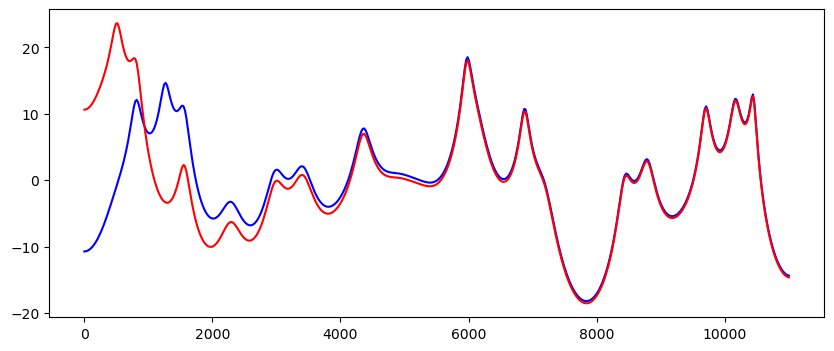

In [20]:
plt.figure(figsize=(10,4))
freqresp = np.empty((framelength//2, nframes), dtype=np.complex128)
w, ref = scipy.signal.freqz([1], vtcoeffs[650,:])
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='blue')
w, ref = scipy.signal.freqz([1],new_vtcoeffs[650,:]) ### HAY QUE NORMALIZAR LA ENERGIA ?????!!!!
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='red')
#plt.semilogx()
plt.show()

In [21]:
# now regenerate the audio

In [22]:
# O recomponemos a partir del new vocal tract nada mas...
audio_output = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = glottis_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    audio_output[idx] += scipy.signal.lfilter([1], new_vtcoeffs[i,:], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

IPython.display.Audio(data=audio_output.T.flatten(), rate=fs,autoplay=True)

In [155]:
# El input, como referencia
IPython.display.Audio(data=audio_input, rate=fs, autoplay=True)

In [32]:
# A la excitacion le hemos sacado primero el vocal tract, y ahora le sacamos la glottis
excitation_frames = librosa.util.frame(excitation_iaif, frame_length=framelength, hop_length=hoplength)
# new glottis
exc_plus_glottis = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = excitation_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    exc_plus_glottis[idx] += scipy.signal.lfilter([1], new_glcoeffs[i,:], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
# new vocal tract
EG_frames = librosa.util.frame(exc_plus_glottis, frame_length=framelength, hop_length=hoplength)
audio_output = np.zeros_like(audio_input)
for i in range(nframes):  
    frame = EG_frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    audio_output[idx] += scipy.signal.lfilter([1], vtcoeffs[i,:], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)


IPython.display.Audio(data=audio_output.T.flatten(), rate=fs,autoplay=True)

### Tenseness & Loudness

In [33]:
gframes = librosa.util.frame(glottis_iaif, frame_length=framelength, hop_length=hoplength)

In [34]:
# Rd = torch.tensor((h1h2(gframes, f0, sr=fs) + 7.6) / 11.1)
Rd = np.empty(nframes)
for i in range(nframes):
    X = librosa.amplitude_to_db(np.abs(librosa.stft(gframes[:,i], n_fft=framelength, hop_length=framelength)))
    h1bin = int(np.round(f0[i] / fs * framelength))
    h2bin = int(np.round(2 * f0[i] / fs * framelength))
    Rd[i] = (X[h1bin,1] - X[h2bin,1] + 7.6) / 11.


In [35]:
tenseness = np.clip(1 - Rd / 3, 0, 1)
plot = figure(title="Tenseness", width=800, height=400, x_axis_label="Frame")
plot.line(np.arange(nframes), tenseness)
show(plot)

In [38]:
loudness = librosa.feature.rms(y=audio_input, frame_length=framelength, hop_length=hoplength)
plot = figure(title="Loudness", width=800, height=400, x_axis_label="Frame")
plot.line(np.arange(nframes), librosa.amplitude_to_db(loudness.T.flatten()))
show(plot)

In [191]:
tenseness[:]*=0.6

In [101]:
f0[:]=260

ValueError: operands could not be broadcast together with shapes (164480,) (1,1294) 

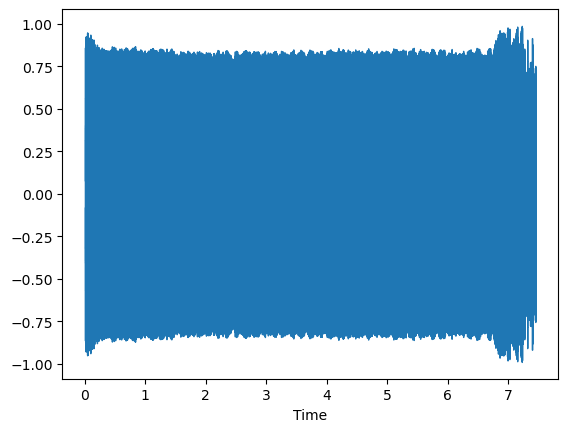

In [39]:
glottis = Glottis(ncilinders, fs)
glottis_signal = glottis.get_waveform(tenseness=torch.Tensor(tenseness), freq=torch.Tensor(f0.reshape(-1, 1)), frame_len=hoplength).detach().numpy()
gframes = librosa.util.frame(glottis_signal, frame_length=framelength, hop_length=hoplength).copy()

librosa.display.waveshow(glottis_signal)
IPython.display.Audio(data=glottis_signal, rate=fs, autoplay=True)

## Curve fitting

In [ ]:
# plot = figure(title="Frequency Response of the Fitted Vocal Tract", width=800, height=400, x_axis_label="Frequency (Hz)", y_axis_label="Magnitude (dB)")

# vt = VocalTractProxy(framelength // 2)

# # damp glottis-lips stationary wave
# vt.r0 = 0.1
# vt.rl = -0.85
# vt.tl = 1 + vt.rl

# vtopt = TractControlsOptimizer(vt)
# Hkl = np.empty((framelength // 2, nframes), dtype=np.complex64)


# # for i in tqdm(range(nframes)):
# for i in tqdm(range(nframes)):
#     target = torch.tensor(freqresp[:,i], dtype=torch.complex64)

#     vtopt.optimize(target, loss_fn=partial(weighted_log_mag_mse_loss, sr=fs), n_iters=20)

#     Hkl[:,i] = vtopt.get_prediction().detach().numpy()

#     plot.line(np.linspace(0, fs // 2, Hkl[:,i].size), librosa.amplitude_to_db(np.abs(freqresp[:,i])), alpha=0.05, color="red")
#     plot.line(np.linspace(0, fs // 2, Hkl[:,i].size), librosa.amplitude_to_db(np.abs(Hkl[:,i])), alpha=0.05)

# show(plot)

In [ ]:
# out = np.zeros_like(input)

# for i in tqdm(range(min(nframes, gframes.shape[1]))):
#     frame = gframes[:, i]
#     framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
#     idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
#     out[idx] += np.fft.irfft(np.fft.rfft(frame * scipy.signal.get_window("hamming", framelength))[0:-1] * Hkl[:,i], n=framelength)

# out = np.nan_to_num(out, nan=0.0)

# IPython.display.Audio(data=out, rate=fs)

  0%|          | 0/1278 [00:00<?, ?it/s]

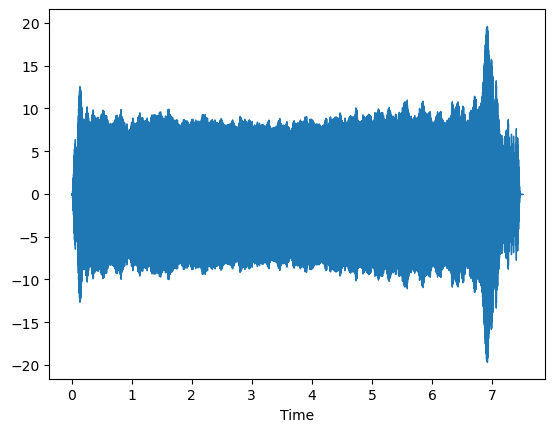

In [198]:
tenseness[:]*=0.1
glottis = Glottis(ncilinders, fs)
glottis_signal = glottis.get_waveform(tenseness=torch.Tensor(tenseness), freq=torch.Tensor(f0.reshape(-1, 1)), frame_len=hoplength).detach().numpy()

gframes = librosa.util.frame(glottis_signal, frame_length=framelength, hop_length=hoplength)

out = np.zeros_like(input)

for i in tqdm(range(min(nframes, gframes.shape[1]))):
    frame = gframes[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    # out[idx] += np.fft.irfft(np.fft.rfft(frame * scipy.signal.get_window("hamming", framelength))[0:-1] * Hkl[:,i], n=framelength)
    out[idx] += scipy.signal.lfilter([1], vtcoeffs[:,i], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

out = np.nan_to_num(out, nan=0.0)
librosa.display.waveshow(out)

IPython.display.Audio(data=out, rate=fs, autoplay=True)

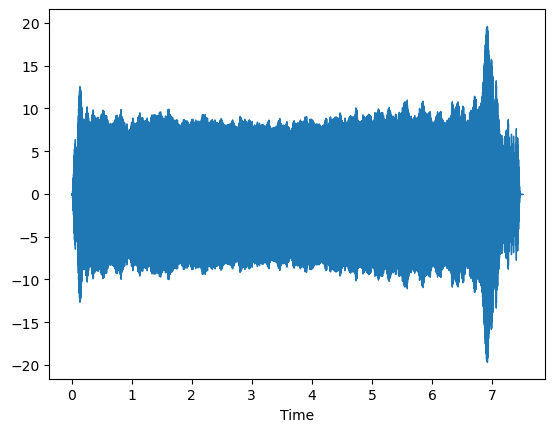

In [199]:
librosa.display.waveshow(out)

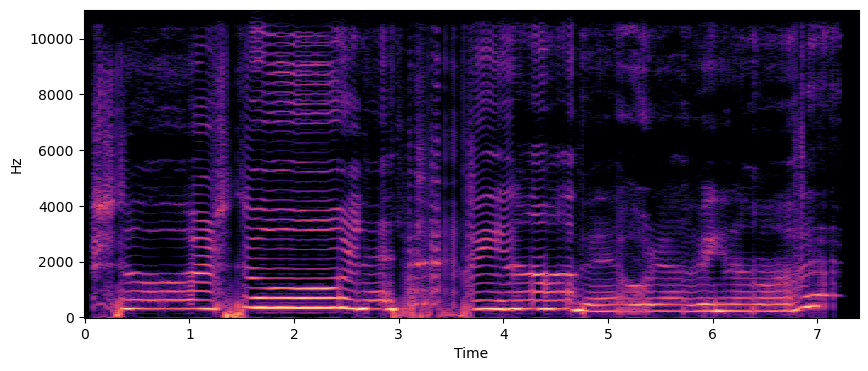

In [30]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(out, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")